### Monitorización de la deriva

Realizaremos la monitorización sobre las observaciones de 2024, pues los datos recopilados de las predicciones son muy escasos

#### Importamos librerías necesarias

In [1]:
import sys
sys.path.append("../")

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import pandas as pd

Cargamos los datos de forecast y las observaciones que hemos usado para entrenamiento

In [3]:
df_train = pd.read_parquet("../clean/df_definitivo.parquet")

df_new = pd.read_parquet("../clean/df_merged_2024.parquet")

# eliminamos repetidas, columnas que no participan en el modelo
df_train.drop(columns=['Temperatura', 'wspd'], inplace=True) 

df_new.drop(columns=['Temperatura', 'wspd'], inplace=True) 

##### Diferencia en tamaño

In [4]:
df_train.shape, df_new.shape

((12810, 36), (1400, 36))

Al haber una gran diferencia del tamaño, vamos a escoger los mismos meses del año que están en el df_new para que el tamaño del conjunto train no sea 10 veces más grande

In [5]:
df_train = df_train[df_train.mes.isin(df_new.mes.unique())]

In [6]:
df_train.shape, df_new.shape

((4716, 36), (1400, 36))

Hemos podido reducir la diferencia en cantidad bastante, además ahora son condiciones más igualadas al trabajar con los mismos meses

## Distribución las variables explicativas más importantes
Nos fijaremos en las importancias de las variables del bosque

Vamos a tener que recuperar el scaler para poder conseguir el orden correcto de las columnas
(ColumnTransformer cambia de orden las columnas asi que no son lo mismo las columnas de df SIN escalar y df CON escaldo)

In [7]:
X_train, y_train = df_train.drop(columns=['AlturaOlas', 'anio', 'mes', 'dia', 'hora']), df_train['AlturaOlas']

scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')
cols_order = scaler.fit_transform(X_train).columns
cols_order

Index(['moonphase', 'temp', 'dewPt', 'heat_index', 'rh', 'pressure', 'vis',
       'wc', 'feels_like', 'uv_index', 'Vviento', 'PeriodoOlas', 'Lluvia',
       'Nubosidad', 'wdir_E', 'wdir_ENE', 'wdir_ESE', 'wdir_N', 'wdir_NE',
       'wdir_NNE', 'wdir_NNW', 'wdir_NW', 'wdir_S', 'wdir_SE', 'wdir_SSE',
       'wdir_SSW', 'wdir_SW', 'wdir_VAR', 'wdir_W', 'wdir_WNW', 'wdir_WSW'],
      dtype='object')

Cargamos el modelo que hemos seleccionado como el mejor

In [8]:
filename = '../modelos/modelo_definitivo/modelo_rf_def.pkl'

with open(filename, 'rb') as file:
    model = pickle.load(file)


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Mostramos las importancias de las variables del modelo

Text(0.5, 1.0, 'Importancias de variables de modelo')

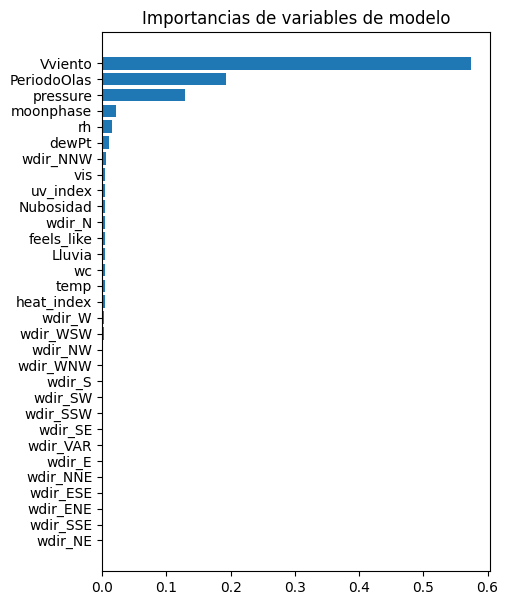

In [9]:
plt.figure(figsize=(5,7))
importancias = pd.DataFrame({'value': model.feature_importances_,'name': cols_order})
importancias = importancias.sort_values(by='value')
plt.barh(y=importancias.name, width=importancias.value)
plt.title('Importancias de variables de modelo')

Según el gráfico, vemos que las tres variables con mayor importancia (con diferencia, además) son la velocidad del viento (Vviento), el período de las olas (PeriodoOlas) y la presión atmosférica (pressure). 

Función auxiliar para pintar las gráficas de distribución de una variable para cada año

In [10]:
def contrast_years(var, xticks, yticks, xlabel):
    fig, axs = plt.subplots(2,2, figsize=(8,10))
    fig.suptitle(var)
    for i, year in enumerate(df_train.anio.unique()):
        axs[i//2, i%2].hist(df_train[df_train.anio == year][var], density=True)
        axs[i//2, i%2].set_title(year)
        axs[i//2, i%2].set_xticks(xticks)
        axs[i//2, i%2].set_yticks(yticks)
        axs[i//2, i%2].set_xlabel(xlabel)
    
    axs[1,1].hist(df_new[var], density=True, label='NEW (2024)', color='red')
    axs[1,1].set_title('NEW (2024)')
    axs[1,1].set_xticks(xticks)
    axs[1,1].set_yticks(yticks)
    axs[1,1].set_xlabel(xlabel)


Funcion auxiliar para pintar boxplots para contrastar por años

In [11]:
def boxplot_years(var, xlabel):
    data = []
    years = []
    fig, ax = plt.subplots(1,1)
    fig.suptitle(var)
    for i, year in enumerate(df_train.anio.unique()):
        data.append(df_train[df_train.anio == year][var])
        years.append(year)

    data.append(df_new[var])
    years.append('NEW (2024)')
    boxy = ax.boxplot(data, vert=0)
    for i, box in enumerate(boxy['boxes']):
        if (i < 3):
            box.set_color('blue')
        else:
            box.set_color('red')
    ax.set_yticklabels(years)
    ax.set_xlabel(xlabel)


### 1. VViento
(nudos)

In [12]:
var = 'Vviento'

Analisis por distintos valores estadísticos

In [13]:
df = pd.concat([df_train[var].describe(), df_new[var].describe()], axis=1)
df.columns = ['OLD ' + var, 'NEW ' + var]
df

,OLD Vviento,NEW Vviento
count,4716.000000,1400.000000
mean,10.723919,12.931429
std,5.516975,6.381566
min,0.000000,1.000000
25%,7.000000,8.000000
50%,10.000000,12.000000
75%,14.000000,17.000000
max,36.000000,42.000000


En este caso parece que el viento es mayor, porque en el nuevo conjunto el máximo está por encima del máximo del conjunto total. Además, tanto la media, como los cuartiles también están por encima.

Lo pasamos a ver por años

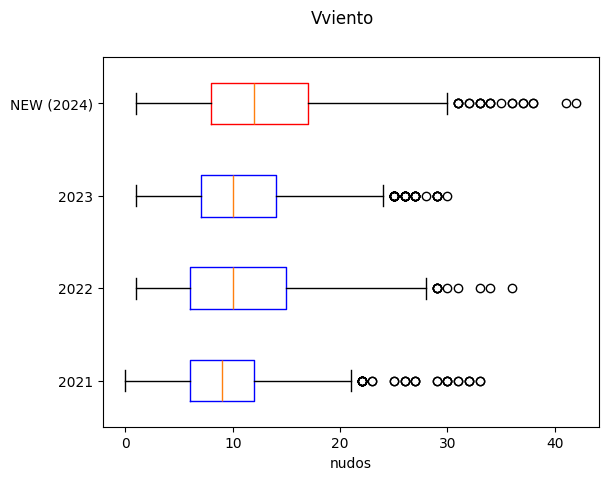

In [14]:
boxplot_years(var, 'nudos')

Viendo este diagrama se confirma lo anterior, vemos que no solo la mediana, y el recorrido intercuartílico están por encima de otros, sino que también es más disperso el conjunto

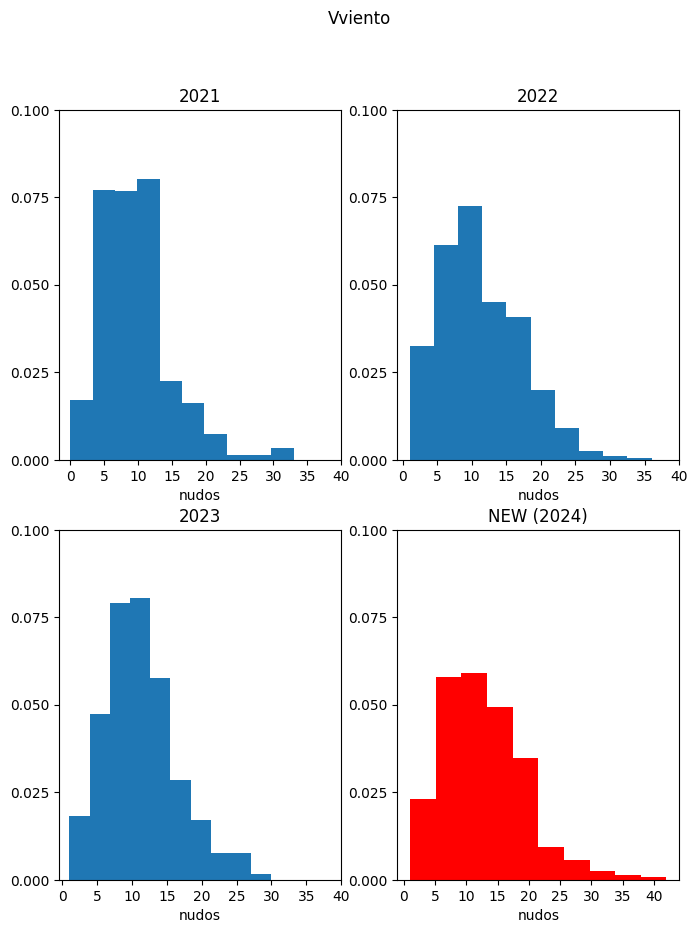

In [15]:
contrast_years(var, [i for i in range(0,43,5)], [i/40 for i in range(0,5,1)], 'nudos')

Aquí se ve de forma notable que la distribución difiere de los otros años, se distribuye un poco más a la derecha que los otros años y no tiene el pico tan alto como las otras distribuciones

### 2. PeriodoOlas
(segundos)

In [16]:
var = 'PeriodoOlas'

Analisis por distintos valores estadísticos

In [17]:
df = pd.concat([df_train[var].describe(), df_new[var].describe()], axis=1)
df.columns = ['OLD ' + var, 'NEW ' + var]
df

,OLD PeriodoOlas,NEW PeriodoOlas
count,4716.000000,1400.000000
mean,8.332061,7.729286
std,3.165629,2.715797
min,0.000000,1.000000
25%,6.000000,6.000000
50%,8.000000,8.000000
75%,10.000000,10.000000
max,19.000000,15.000000


Para el Perido de las olas podemos afirmar que se parecen bastante, coincidiendo en varios cuartiles, vamos a verlo por años

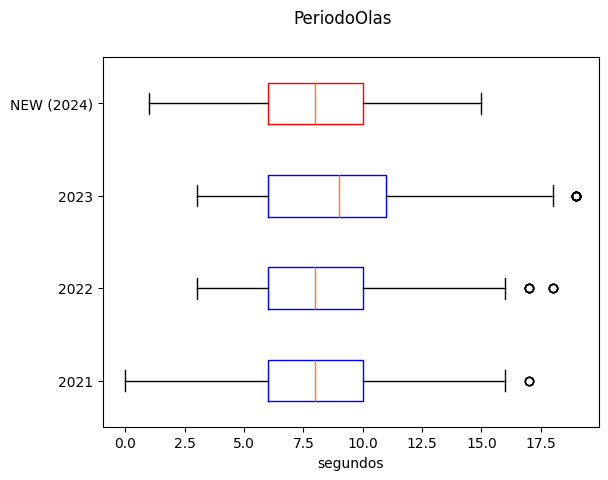

In [18]:
boxplot_years(var, 'segundos')

Los recorridos intercuartílicos son muy parecidos entre sí, excepto el 2023. Podemos decir que en este caso está un poco por debajo de las distribuciones anteriores

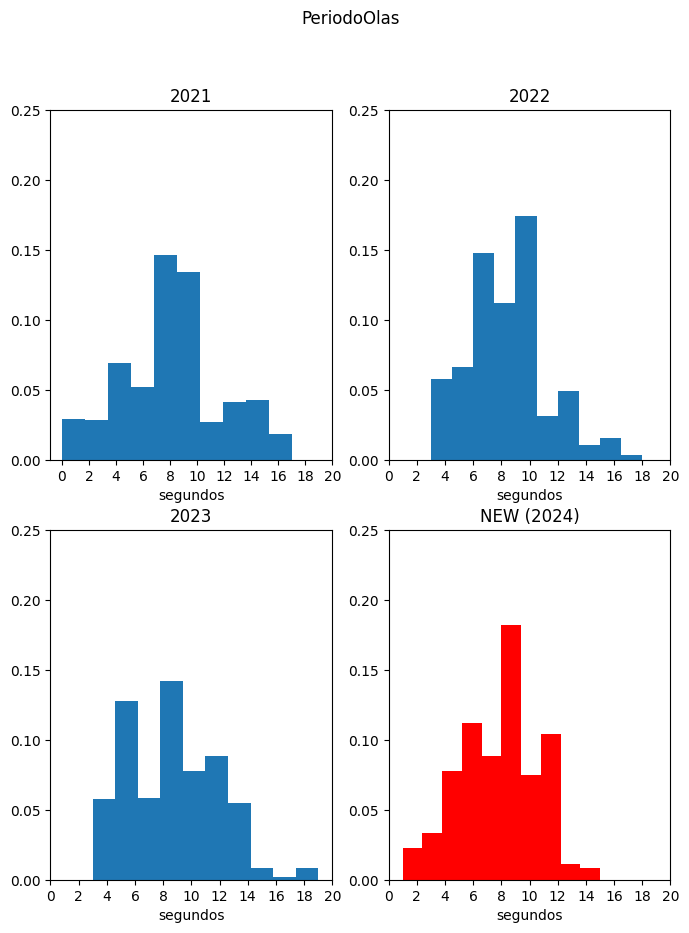

In [19]:
contrast_years(var, [i for i in range(0,21,2)], [i/20 for i in range(0,6,1)], 'segundos')

Concluimos que se parece bastante a las distribuciones de los otros años, por ello podemos decir que para esta variable no ha ocurrido un cambio en la distribución

### 3. PRESION
(inHg, pulgadas de mercurio)

In [20]:
var = 'pressure'

Analisis por distintos valores estadísticos

In [21]:
df = pd.concat([df_train[var].describe(), df_new[var].describe()], axis=1)
df.columns = ['OLD ' + var, 'NEW ' + var]
df

,OLD pressure,NEW pressure
count,4716.000000,1400.000000
mean,29.927596,29.701582
std,0.371725,0.452594
min,28.730000,28.460000
25%,29.685000,29.415000
50%,29.960000,29.715000
75%,30.230000,30.050000
max,30.790000,30.610000


Con la tabla es relativamente difícil sacar conclusiones, vamos a verlo con el boxplot

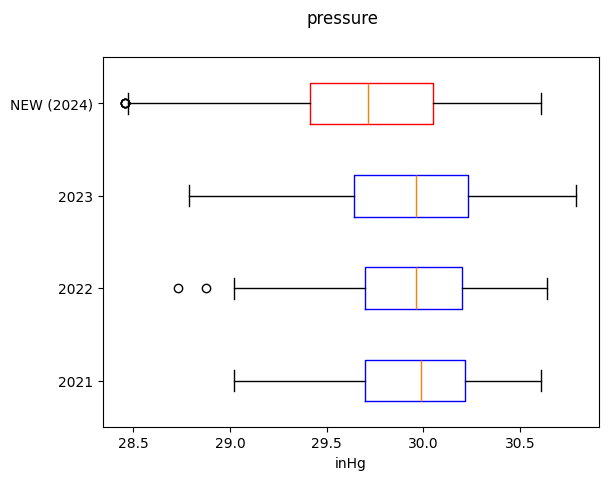

In [22]:
boxplot_years(var, 'inHg')

Parece ser que en este caso la presión está bastante por debajo de los otros años.

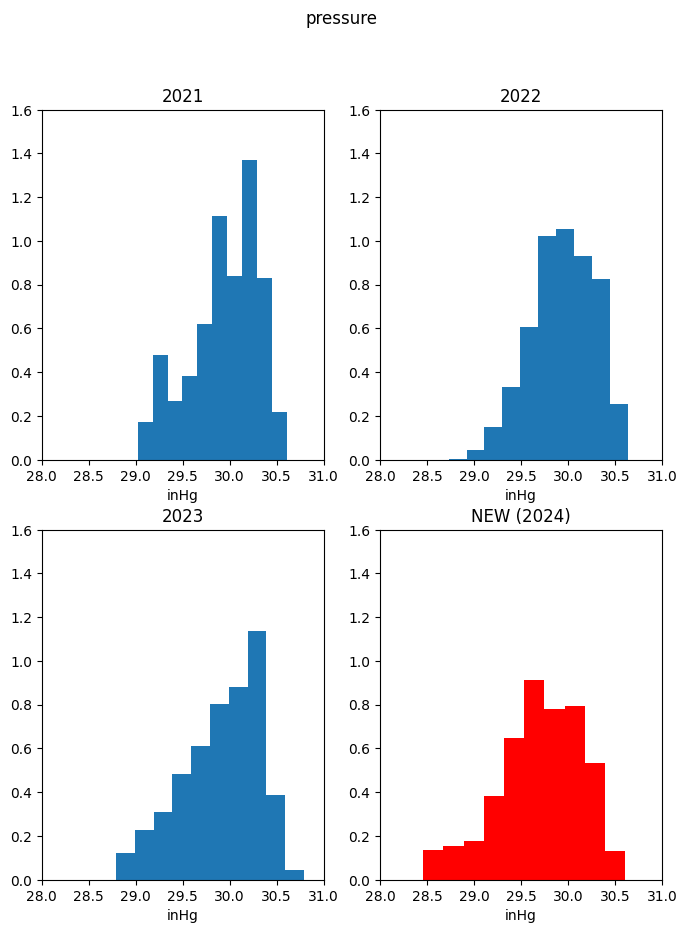

In [23]:
contrast_years(var, [28+i/10 for i in range(0,31,5)], [i/10 for i in range(0,17,2)], 'inHg')

Pero analizando los histogramas nos damos cuenta de que las distribuciones son las más parecidas de las tres variables analizadas anteriormente, así que podemos afirmar que la presión atmosférica no cambia significativamente de distribución.

En conclusión, de las tres variables que hemos seleccionado, la que mayor diferencia parece tener con las distribuciones de los años anteriores es la de Vviento o velocidad de viento. Esto podría afectar nuestro modelo, pues es la variable de mayor importancia del modelo

## Distribución las alturas de las olas

In [24]:
var = 'AlturaOlas'

In [25]:
df = pd.concat([df_train[var].describe(), df_new[var].describe()], axis=1)
df.columns = ['OLD ' + var, 'NEW ' + var]
df

,OLD AlturaOlas,NEW AlturaOlas
count,4716.000000,1400.000000
mean,1.267981,1.655429
std,0.929943,1.103526
min,0.000000,0.200000
25%,0.600000,0.900000
50%,1.000000,1.500000
75%,1.700000,2.200000
max,6.900000,7.400000


Lo primero que se aprecia es que en tres años anteriores no hubo una ola tan grande como en este año, algo que puede ser evidencia de que la distribución ha cambiado

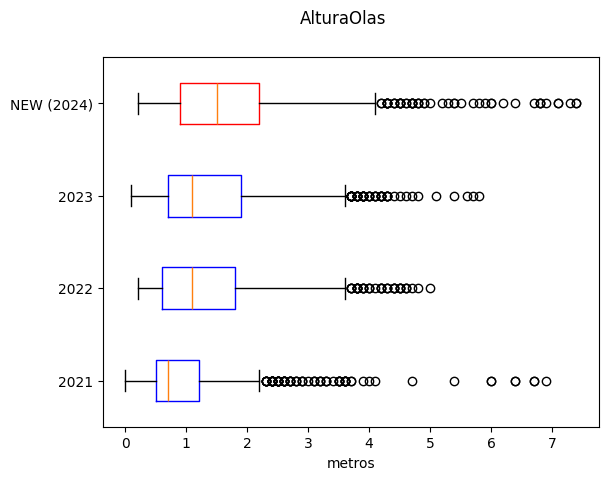

In [26]:
boxplot_years(var, 'metros')

Vemos que la mediana está por encima de las medianas de los otros años. Además, hay más olas que están por encima de 6 metros que en cualquier año anterior.

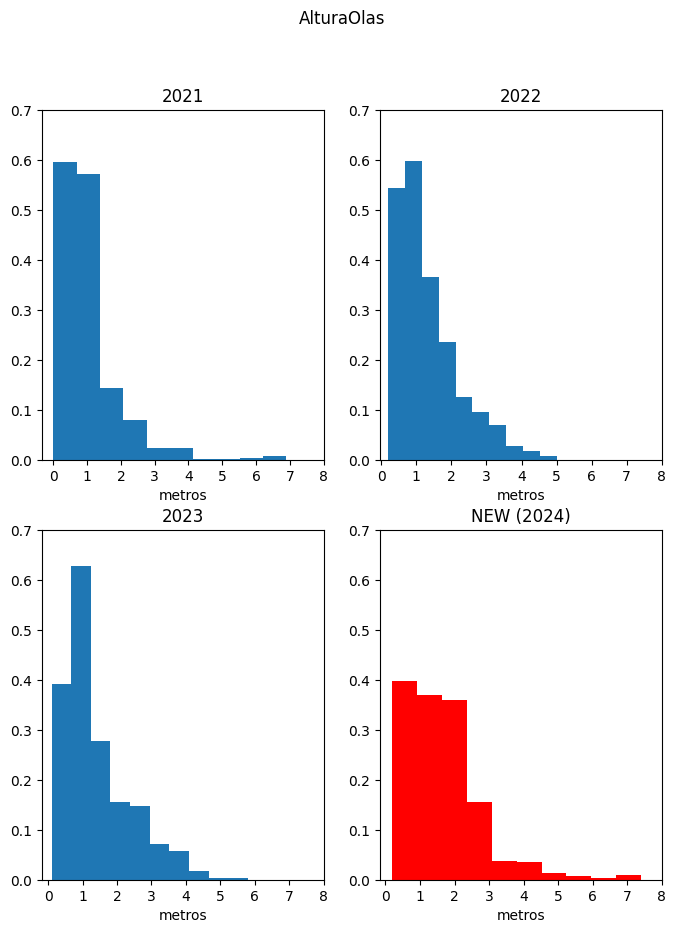

In [27]:
contrast_years(var, [i for i in range(0,9,1)], [i/10 for i in range(0,8,1)], 'metros')

Aqui vemos que también es diferente la distribución de las otras, pues en este caso no aparece un pico en la parte de la izquierda que indica muchísimas olas bajitas.

In [28]:
def class_ola(ola):
    if (ola < 1):
        return "x<1"
    if (ola < 2):
        return "1<x<2"
    if (ola < 3):
        return "2<x<3"
    else:
        return "x>3"

Ya que en el análisis hemos segmentado las olas por grupos, veamos que pasa si realizamos el análisis sobre olas segmentadas

In [33]:
df_train.anio.unique()

array([2021, 2022, 2023])

In [34]:
segmentos_train_2021 = df_train[df_train.anio == 2021].AlturaOlas.map(class_ola)
segmentos_train_2022 = df_train[df_train.anio == 2022].AlturaOlas.map(class_ola)
segmentos_train_2023 = df_train[df_train.anio == 2023].AlturaOlas.map(class_ola)
segmentos_new = df_new.AlturaOlas.map(class_ola)

In [35]:
order = ["x<1", "1<x<2", "2<x<3", "x>3"]

Text(0, 0.5, 'Cantidad')

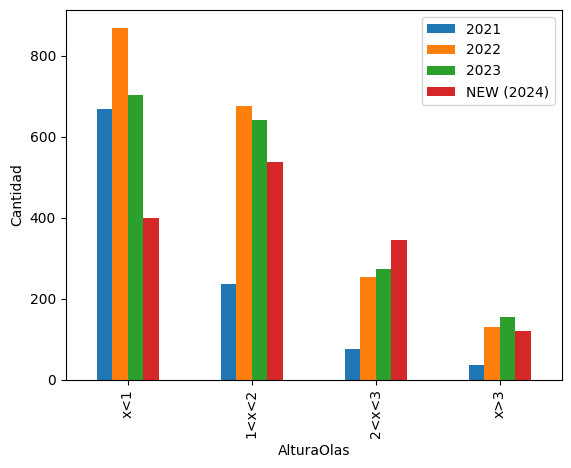

In [36]:
df = pd.DataFrame({
    '2021':  segmentos_train_2021.value_counts()[order],
    '2022':  segmentos_train_2022.value_counts()[order],
    '2023':  segmentos_train_2023.value_counts()[order],
    'NEW (2024)': segmentos_new.value_counts()[order]
})

df.plot(kind='bar', stacked=False)
plt.ylabel('Cantidad')

Al verlo por cantidad, podemos apreciar que según como hemos planteado los segmentos, hay mucha diferencia entre los años en general, no solo del 2024 con los anteriores. Sobre todo el 2021 difiere mucho de los otros grupos.

En conclusión, afirmamos que la distribución de las Alturas de las Olas ha cambiado, a pesar de que en los segmentos seleccionados por nosotros se parece, no podemos decir lo mismo para los histogramas, que lo hacen de forma más precisa